In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
from diffusion.models.network import ResUNet, get_network
from tqdm.notebook import tqdm
import os
from torchvision import transforms
import json
from datahandler.dataset import NPDataset, make_dataset, RandomRotate90
import matplotlib.pyplot as plt
from diffusion.dm import DiscreteSBM, get_diffusion_model, DiffusionModel
from diffusion.stochastic.sde import DiscreteVPSDE, DiscreteSigmaVPSDE, get_sde, DiscreteSDE
from utils.scheduler import get_optimizer_and_scheduler, InverseSquareRootScheduler
import runners as runners

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
N_diff = 1000
amin, amax = -5, 5
CKPT_DIR = "/mnt/home/dheurtel/ceph/02_checkpoints"
SAMPLE_DIR = "/mnt/home/dheurtel/ceph/03_samples"

In [4]:
train_dataset, test_dataset = make_dataset("CATS_MHD_BPROJ_DENSITY", seed=33, split=0.1)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)

In [5]:
sde = DiscreteVPSDE(N_diff)

In [6]:
data = next(iter(train_dataloader))
data = data.to(device)
data = data.unsqueeze(1)
timesteps = (torch.randint(0, 1000, (data.shape[0],))).long().to(device)

x_tilde, mean, noise = sde.sampling(data, timesteps)

The SDE object manages forward time direct sampling (from time 0 to a given time t), as well as the drift, brownian formulation of the SDE. 
It also encompasses methods to do reverse sampling (given a score network, see this[reference]) as well as likelihood computations

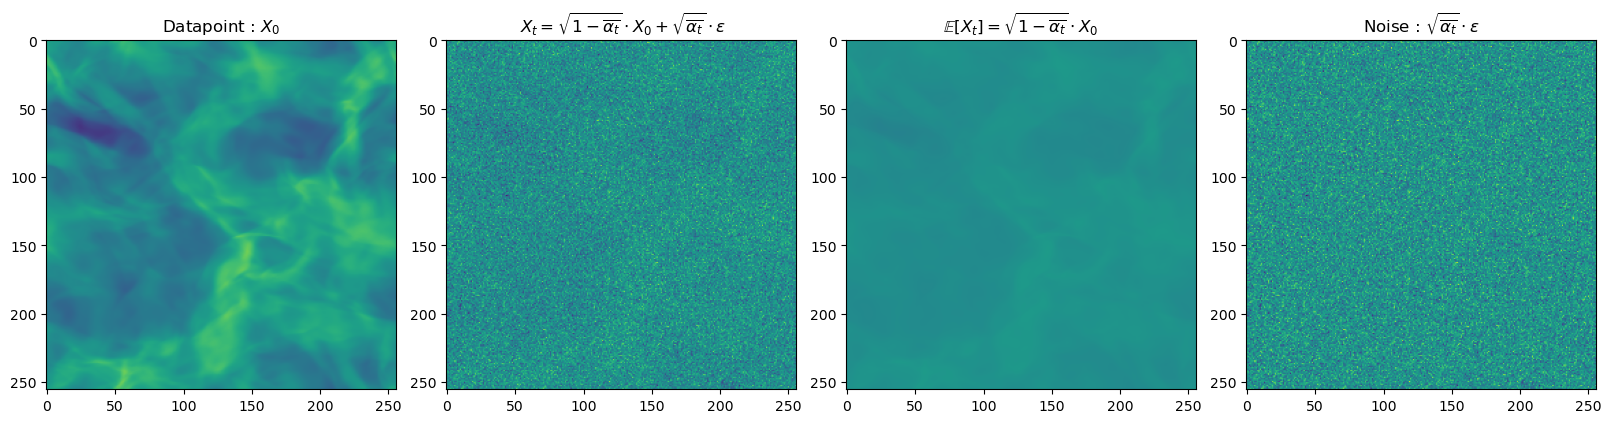

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16,4), layout = 'constrained')
axs[0].imshow(data[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[0].set_title("Datapoint : $X_0$")
axs[1].imshow(x_tilde[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[1].set_title(" $X_t = \sqrt{1-\overline{\\alpha_t}}\cdot X_0 +  \sqrt{\overline{\\alpha_t}}\cdot \epsilon$")
axs[2].imshow(mean[0, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
axs[2].set_title("$\mathbb{E}[X_t] = \sqrt{1-\overline{\\alpha_t}}\cdot X_0$")
axs[3].imshow(noise[0, 0, :, :].cpu().numpy(),)
axs[3].set_title("Noise : $\sqrt{\overline{\\alpha_t}}\cdot \epsilon$")
plt.show()

In [8]:
network = ResUNet(1, 1, 10, num_blocks=1, n_steps=1000, time_emb_dim=100, dropout=0, attention=[], normalisation="GN", padding_mode="circular", eps_norm=1e-5, skiprescale=True)

TODO add the image?

In [9]:
model = DiscreteSBM(sde, network).to(device)

In [10]:
gen = model.generate_image(sample_size=4)

100%|██████████| 1000/1000 [00:07<00:00, 134.64it/s]


Text(0.5, 0.98, 'Generated images')

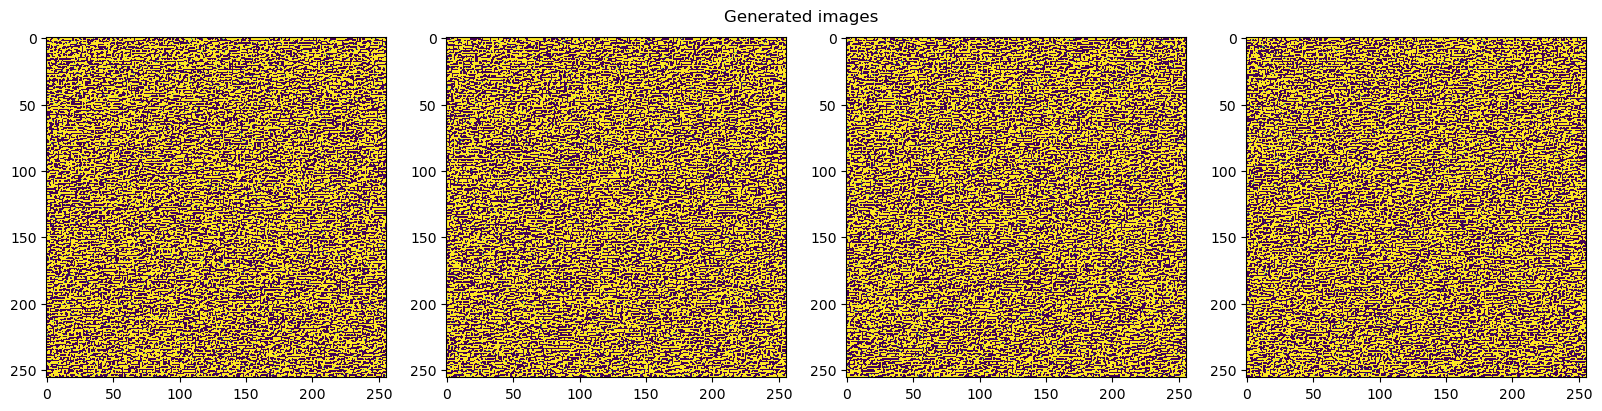

In [11]:
## Plot the generated images
fig, axs = plt.subplots(1, 4, figsize=(16,4), layout = 'constrained')
for i in range(4):
    axs[i].imshow(gen[i, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
fig.suptitle("Generated images")

As you can see, the model is untrained and images that are generated are saturated (compared to the initial dataset). If you were to remove the color bar range, you would see noise.

To generate images, we need to train the network, or get weight from a pretrained model. 

The Diffuser object bundles together a diffusion model (already having the SDE you want to use and an (untrained) network) and tools to make training easier (saving and loading checkpoints, saving and loading architecures through configuration files or dictionnary, generating and saving samples).

In [12]:
diffuser = runners.Diffuser(model, train_dataloader = train_dataloader, test_dataloader = test_dataloader)

No model id found


Let's see what's inside the diffuser. We provided a model and two dataloaders

In [13]:
diffuser.get_config()

No model id found


{'diffusion_model': {'sde': {'type': 'DiscreteVPSDE',
   'beta_min': 0.1,
   'beta_max': 20.0,
   'ddpm_math': True,
   'N': 1000},
  'network': {'in_c': 1,
   'out_c': 1,
   'first_c': 10,
   'sizes': [256, 128, 64, 32],
   'num_blocks': 1,
   'n_steps': 1000,
   'time_emb_dim': 100,
   'dropout': 0,
   'attention': [],
   'normalisation': 'GN',
   'padding_mode': 'circular',
   'eps_norm': 1e-05,
   'skiprescale': True,
   'type': 'ResUNet'},
  'type': 'DiscreteSBM'},
 'dataloaders': {}}

None of the dataloaders had any config file attached to them so we do not have any info on them when calling diffuser.get_config. We do not have any optimizer or scheduler either, nore any information for checkpointing or sampling.

#### Training the network



In [14]:
losses, test_losses = diffuser.train(epochs = 25)

/mnt/home/dheurtel/AstroDDPM/runners.py:527: UserWarning: Either model_id or sample dir not provided ==> no sample will we generated either during training or at the end.
  warnings.warn("Either model_id or sample dir not provided ==> no sample will we generated either during training or at the end.")
/mnt/home/dheurtel/AstroDDPM/runners.py:541: UserWarning: No ckpt dir provided ==> no checkpoint will be saved.
  warnings.warn("No ckpt dir provided ==> no checkpoint will be saved.")
/mnt/home/dheurtel/AstroDDPM/runners.py:364: UserWarning: No ckpt dir or model id found ==> not saving the config.
  warnings.warn("No ckpt dir or model id found ==> not saving the config.")
/mnt/home/dheurtel/AstroDDPM/runners.py:369: UserWarning: Error when saving the checkpoint, save it manually using save_ckpt(for_training = ...) and check the arguments you provide.
  warnings.warn("Error when saving the checkpoint, save it manually using save_ckpt(for_training = ...) and check the arguments you provide

No optimizer provided, using Adam with lr=1e-3 and setting the corresponding attr to it.
Epochs provided as argument, using it instead of a possible one as attribute and setting the epochs attribute to it.
No model id found


Epoch 24: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s, loss=0.0396, step=349]


Training finished. Final sampling and checkpointing.


The training method warns that we have not provided an optimizer, let's ignore that for now as we will touch that in more detail after. It also indicates that because we provided an epochs argument as input, it will disregard any existing epochs attribute. The idea is to be able to resume training when something happens. Let's say the model has epoch 83 as attribute and epochs as 100. If we do not probide any epochs (or epoch) arg to the train method, the model will just complete the training for the remaining epochs (84 to 99). 

diffuser.train() returns the losses and test losses, we can plot them

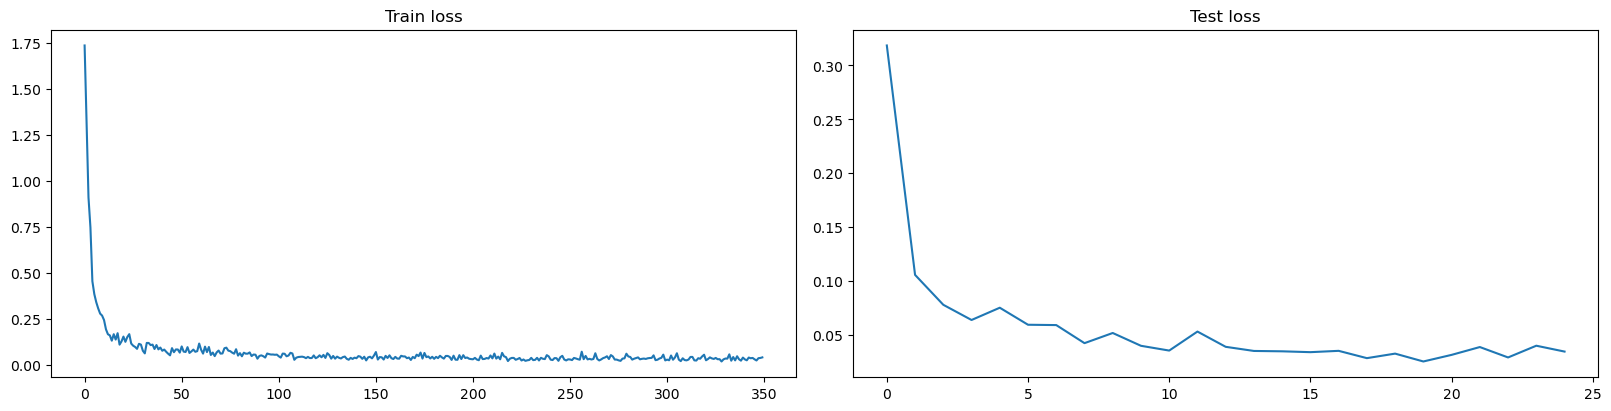

In [15]:
## Plot the losses

fig, axs = plt.subplots(1, 2, figsize=(16,4), layout = 'constrained')
axs[0].plot(losses)
axs[0].set_title("Train loss")
axs[1].plot(test_losses)
axs[1].set_title("Test loss")
plt.show()

We have trained the network for 10 epochs. Let's see generate and print some samples

100%|██████████| 1000/1000 [00:06<00:00, 161.32it/s]


Text(0.5, 0.98, 'Generated images')

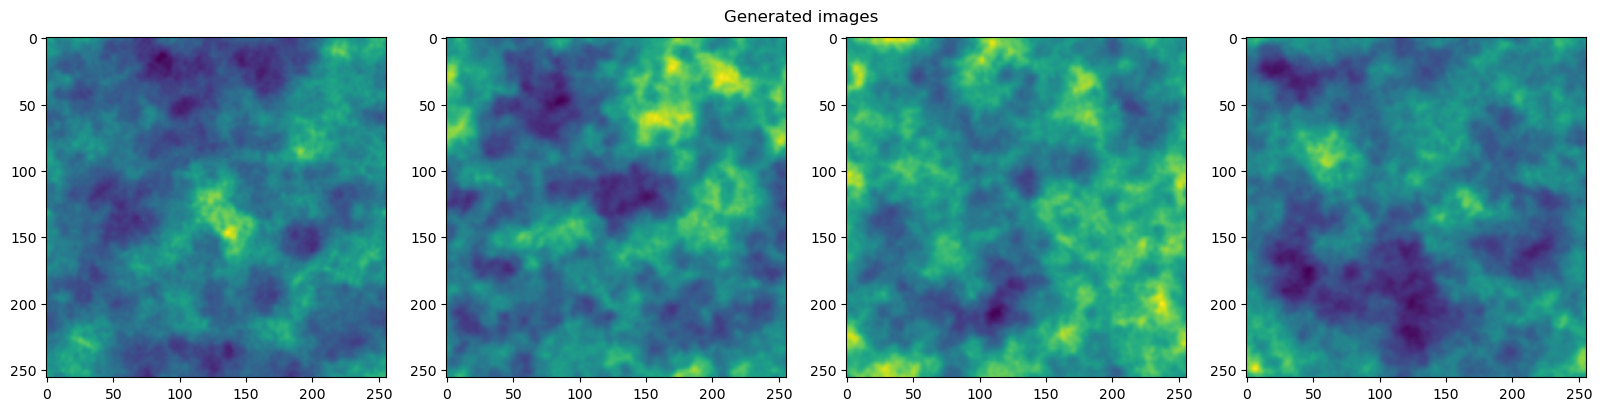

In [16]:
gen = diffuser.diffmodel.generate_image(sample_size=4)

## Plot the generated images
fig, axs = plt.subplots(1, 4, figsize=(16,4), layout = 'constrained')
for i in range(4):
    axs[i].imshow(gen[i, 0, :, :].cpu().numpy(), ) #vmin=amin, vmax=amax
fig.suptitle("Generated images")

We have structure in the images but they are still far from good samples (notice the lack of colorbar normalization). We need to train more. Before we do that (and add a few items to make our life easier), let's see what happened to our diffuser:

In [17]:
diffuser.get_config()

No model id found


{'diffusion_model': {'sde': {'type': 'DiscreteVPSDE',
   'beta_min': 0.1,
   'beta_max': 20.0,
   'ddpm_math': True,
   'N': 1000},
  'network': {'in_c': 1,
   'out_c': 1,
   'first_c': 10,
   'sizes': [256, 128, 64, 32],
   'num_blocks': 1,
   'n_steps': 1000,
   'time_emb_dim': 100,
   'dropout': 0,
   'attention': [],
   'normalisation': 'GN',
   'padding_mode': 'circular',
   'eps_norm': 1e-05,
   'skiprescale': True,
   'type': 'ResUNet'},
  'type': 'DiscreteSBM'},
 'dataloaders': {},
 'optimizer': {'type': 'Adam', 'lr': 0.001},
 'scheduler': {}}

We can see that the default optimizer was added to the config files (and a simple check will show it is part of the class attributes too now). No model id was ever provided. Let's suppose we want to train for longer, or in a python script, not a jupyter notebook. We might want to save the model weights to reuse them later, we might also want to save the model configuration to be able to load these weights in a compatible architecture. First of all, we will add a model id to this diffuser, as well as a checkpoint directory to save its weight under ckpt_path/model_id. We will also order the model to generate samples every so often during training. This will allow us to check how the training is going.

In [18]:
diffuser.set_model_id("DemoDDPM")

In [19]:
## Add option for a general ckpt_dir?
diffuser.set_ckpt_sample(ckpt_dir = CKPT_DIR, sample_dir = SAMPLE_DIR, ckpt_epoch= 25, sample_epoch= 25, sample_size = 8, results_size=64)

In [20]:
os.listdir(CKPT_DIR)

['DemoDDPM3', 'DemoDDPM2', 'DefaultDDPM', 'DemoDDPM']

In [21]:
diffuser.get_config()

{'diffusion_model': {'sde': {'type': 'DiscreteVPSDE',
   'beta_min': 0.1,
   'beta_max': 20.0,
   'ddpm_math': True,
   'N': 1000},
  'network': {'in_c': 1,
   'out_c': 1,
   'first_c': 10,
   'sizes': [256, 128, 64, 32],
   'num_blocks': 1,
   'n_steps': 1000,
   'time_emb_dim': 100,
   'dropout': 0,
   'attention': [],
   'normalisation': 'GN',
   'padding_mode': 'circular',
   'eps_norm': 1e-05,
   'skiprescale': True,
   'type': 'ResUNet'},
  'type': 'DiscreteSBM'},
 'dataloaders': {},
 'optimizer': {'type': 'Adam', 'lr': 0.001},
 'scheduler': {},
 'ckpt_epoch': 25,
 'separate_ckpt': False,
 'ckpt_dir': '/mnt/home/dheurtel/ceph/02_checkpoints',
 'sample_epoch': 25,
 'sample_dir': '/mnt/home/dheurtel/ceph/03_samples',
 'sample_size': 8,
 'results_size': 64,
 'model_id': 'DemoDDPM'}

Only one (essential) thing is missing from the diffuser, a learning rate scheduler. Let's try to add an InverseSquareRootScheduler:

In [22]:
scheduler = InverseSquareRootScheduler(diffuser.optimizer, warmup=100, maxlr=3e-3, minlr=1e-4, last_step=-1) ## Last step - 1 means we start at the beginning of the scheduler/never used it
scheduler.config = {
            "type": "invsqrt",
            "warmup": 100,
            "maxlr": 0.003,
            "minlr": 0.0001
        }
diffuser.scheduler = scheduler

In [23]:
diffuser.get_config()

{'diffusion_model': {'sde': {'type': 'DiscreteVPSDE',
   'beta_min': 0.1,
   'beta_max': 20.0,
   'ddpm_math': True,
   'N': 1000},
  'network': {'in_c': 1,
   'out_c': 1,
   'first_c': 10,
   'sizes': [256, 128, 64, 32],
   'num_blocks': 1,
   'n_steps': 1000,
   'time_emb_dim': 100,
   'dropout': 0,
   'attention': [],
   'normalisation': 'GN',
   'padding_mode': 'circular',
   'eps_norm': 1e-05,
   'skiprescale': True,
   'type': 'ResUNet'},
  'type': 'DiscreteSBM'},
 'dataloaders': {},
 'optimizer': {'type': 'Adam', 'lr': 0.001},
 'scheduler': {'type': 'invsqrt',
  'warmup': 100,
  'maxlr': 0.003,
  'minlr': 0.0001},
 'ckpt_epoch': 25,
 'separate_ckpt': False,
 'ckpt_dir': '/mnt/home/dheurtel/ceph/02_checkpoints',
 'sample_epoch': 25,
 'sample_dir': '/mnt/home/dheurtel/ceph/03_samples',
 'sample_size': 8,
 'results_size': 64,
 'model_id': 'DemoDDPM'}

Ok, we will add a dataloaders config (only needed on the train_dataloader) then reset the model weights and train to see what happens. 

In [24]:
diffuser.train_dataloader.config = {
    "train_batch_size": 64,
    "test_batch_size": 128,
    "num_workers": 8,
    "seed": 33,
    "split": 0.1,
    "dataset": {
        "dir": "/mnt/home/dheurtel/ceph/01_data/CATS_MHD_BPROJ_DENSITY/",
        "type": "npy files",
        "transforms": [
            "Random_Rotate90"
        ],
        "name": "CATS_MHD_BPROJ_DENSITY"
    }
}

In [25]:
diffuser.diffmodel.network = ResUNet(1, 1, 10, num_blocks=1, n_steps=1000, time_emb_dim=100, dropout=0, attention=[], normalisation="GN", padding_mode="circular", eps_norm=1e-5, skiprescale=True)
## This resets the model weights. 
diffuser.get_config()

{'diffusion_model': {'sde': {'type': 'DiscreteVPSDE',
   'beta_min': 0.1,
   'beta_max': 20.0,
   'ddpm_math': True,
   'N': 1000},
  'network': {'in_c': 1,
   'out_c': 1,
   'first_c': 10,
   'sizes': [256, 128, 64, 32],
   'num_blocks': 1,
   'n_steps': 1000,
   'time_emb_dim': 100,
   'dropout': 0,
   'attention': [],
   'normalisation': 'GN',
   'padding_mode': 'circular',
   'eps_norm': 1e-05,
   'skiprescale': True,
   'type': 'ResUNet'},
  'type': 'DiscreteSBM'},
 'dataloaders': {'train_batch_size': 64,
  'test_batch_size': 128,
  'num_workers': 8,
  'seed': 33,
  'split': 0.1,
  'dataset': {'dir': '/mnt/home/dheurtel/ceph/01_data/CATS_MHD_BPROJ_DENSITY/',
   'type': 'npy files',
   'transforms': ['Random_Rotate90'],
   'name': 'CATS_MHD_BPROJ_DENSITY'}},
 'optimizer': {'type': 'Adam', 'lr': 0.001},
 'scheduler': {'type': 'invsqrt',
  'warmup': 100,
  'maxlr': 0.003,
  'minlr': 0.0001},
 'ckpt_epoch': 25,
 'separate_ckpt': False,
 'ckpt_dir': '/mnt/home/dheurtel/ceph/02_checkpoi

First, we will save this model configuration among all the models (as well as it's checkpoint but for now the checkpoint is useless)

In [26]:
with open(os.path.join(os.getcwd(),'config','MODELS.json')) as f:
    all_config = json.load(f)
print(all_config.keys())
os.listdir(os.path.join(CKPT_DIR, "DemoDDPM"))

dict_keys(['DefaultDDPM'])


['config.json', 'ckpt.pt']

In [27]:
diffuser.save(all_models = True, also_ckpt=True, for_training=True)

Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM


In [28]:
with open(os.path.join(os.getcwd(),'config','MODELS.json')) as f:
    all_config = json.load(f)
print(all_config.keys())

dict_keys(['DefaultDDPM', 'DemoDDPM'])


Now we can delete the diffuser and "recreate it" from the config (but not checkpoint, although the weights would be useless)

In [29]:
diffuser, model, train_dataloader, test_dataloader, optimizer, scheduler = None, None, None, None, None, None
default_diffmodel = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
## Method 1:
#config = runners.config_from_id("DemoDDPM")
#diffuser = runners.Diffuser(default_diffmodel, config=config)

## Method 2:
diffuser = runners.Diffuser(default_diffmodel,)
config = runners.config_from_id("DemoDDPM")
diffuser.load(config = runners.config_from_id("DemoDDPM"), also_ckpt=True, for_training=False) 

No model id found
Loading the diffuser from a config dict.
Loading only the weights, no optimizer or scheduler.


By default, we using method 1, the checkpoint is not loaded. Comment method 1 and uncomment method 2, you will also load the checkpoint, as specified in the load method.

Because the checkpoint we are loading was created from an untrained model, weights are useless. Also, because I will start training from the beginning, I am using for_training = False to avoid loading previous losses, number of epoch....

Let's say the diffuser we just created was in fact a very usefull diffuser. We might not want to overwrite its weight if we finetune it, or we might not want to overwrite its config file if we change one attribute. 

***For this reason, you should always change the model id after you load a diffuser.***

In [30]:
diffuser.set_model_id("DemoDDPM2")

Model id was changed from DemoDDPM to DemoDDPM2.


#### More detail on how the diffuser works

In addition to a diffusion model (attribute diffmodel), one can add to the diffuser:
- an optimizer. For now, only Adam, AdamW and SGD are implemented
- a learning rate scheduler to adapt the learning rate of the optimizer during training
- at least a train_dataloader supplying the training examples. 
- an optional but highly recommended test_dataloader.
- attributes and object to manage logging, checkpointing and sampling

Longer training with all options activated!

Depending on your GPU, it will take between 30 min and 2 hours. Go take a coffee break (or reduce the number of epochs if you don't want to wait but you might not see checkpointing/sampling), read Yang Song's paper or delve into more details by looking at the demo2 (more hands on, more tools...likelihood computations for example).

In [31]:
losses, test_losses = diffuser.train(epochs = 500)

Epochs provided as argument, using it instead of a possible one as attribute and setting the epochs attribute to it.
Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  4.70it/s, loss=0.795, step=12]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 25: 100%|██████████| 13/13 [00:02<00:00,  4.71it/s, loss=0.0287, step=337]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 50: 100%|██████████| 13/13 [00:02<00:00,  4.77it/s, loss=0.0394, step=662]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 75: 100%|██████████| 13/13 [00:02<00:00,  4.75it/s, loss=0.0224, step=987]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 100: 100%|██████████| 13/13 [00:02<00:00,  4.75it/s, loss=0.0162, step=1312]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 125: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s, loss=0.0285, step=1637]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 150: 100%|██████████| 13/13 [00:02<00:00,  4.72it/s, loss=0.0253, step=1962]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 175: 100%|██████████| 13/13 [00:02<00:00,  4.75it/s, loss=0.0322, step=2287]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 200: 100%|██████████| 13/13 [00:02<00:00,  4.79it/s, loss=0.0176, step=2612]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 225: 100%|██████████| 13/13 [00:02<00:00,  4.76it/s, loss=0.0294, step=2937]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 250: 100%|██████████| 13/13 [00:02<00:00,  4.80it/s, loss=0.0192, step=3262]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 275: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s, loss=0.0256, step=3587]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 300: 100%|██████████| 13/13 [00:02<00:00,  4.74it/s, loss=0.0276, step=3912]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 325: 100%|██████████| 13/13 [00:02<00:00,  4.71it/s, loss=0.0305, step=4237]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 350: 100%|██████████| 13/13 [00:02<00:00,  4.74it/s, loss=0.0273, step=4562]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 375: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s, loss=0.0245, step=4887]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 400: 100%|██████████| 13/13 [00:02<00:00,  4.76it/s, loss=0.0239, step=5212]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 425: 100%|██████████| 13/13 [00:02<00:00,  4.77it/s, loss=0.0246, step=5537]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 450: 100%|██████████| 13/13 [00:02<00:00,  4.76it/s, loss=0.0334, step=5862]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 475: 100%|██████████| 13/13 [00:02<00:00,  4.77it/s, loss=0.0175, step=6187]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


Epoch 499: 100%|██████████| 13/13 [00:02<00:00,  4.75it/s, loss=0.0216, step=6499]


Training finished. Final sampling and checkpointing.


100%|██████████| 1000/1000 [00:45<00:00, 22.15it/s]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


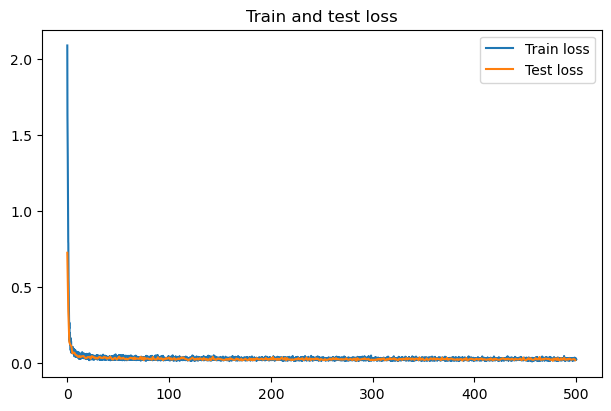

In [38]:
## Plot the losses on the same image, knowing that the test loss is only computed every epoch

fig, axs = plt.subplots(1, 1, figsize=(6,4), layout = 'constrained')

axs.plot(np.arange(0,len(test_losses), len(test_losses)/len(losses)),losses, label = "Train loss")
axs.plot(test_losses, label = "Test loss")
axs.set_title("Train and test loss")
axs.legend()
plt.show()


100%|██████████| 1000/1000 [00:06<00:00, 161.64it/s]


Text(0.5, 0.98, 'Generated images')

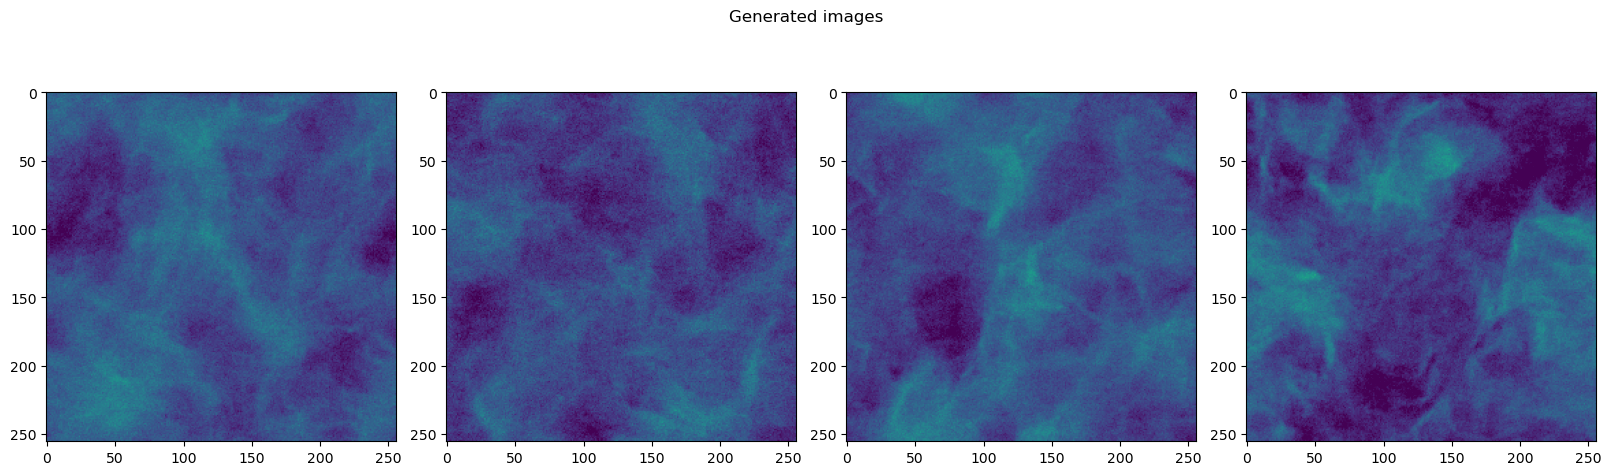

In [42]:
## Plot some samples from the model

gen = diffuser.diffmodel.generate_image(sample_size=4)

## Plot the generated images
fig, axs = plt.subplots(1, 4, figsize=(16,5), layout = 'constrained')
for i in range(4):
    axs[i].imshow(gen[i, 0, :, :].cpu().numpy(), vmin=amin, vmax=amax)
fig.suptitle("Generated images")

It may not seem better (there is a luck factor and we may need more epochs to see improvement in sample quality). 

If you want to explore summary statistics of generated samples vs datapoints, use checkSummaryStat.ipynb. If you want to look at more samples as well as check the losses, potential overfitting and denoising power, use checkTraining.ipynb. Finally, if you want to examine source separation, you can do that with the different source_separation.ipynb, but you should first take a look at the demo2.ipynb notebook.

In [43]:
## We are happy with the results, let's save the model

diffuser.save(all_models = True, also_ckpt=True, for_training=True)

Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM2


In [44]:
with open(os.path.join(os.getcwd(),'config','MODELS.json')) as f:
    all_config = json.load(f)
print(all_config.keys())

dict_keys(['DefaultDDPM', 'DemoDDPM', 'DemoDDPM2'])


## Summary

To summarise, let's create a third and final diffuser in the most compact way possible. We won't train it for long. I encourage you to interrupt the training AFTER THE FIRST CHECKPOINT (in this case epoch 25) then relaunch it.

In [9]:
config  = runners.config_from_id("DefaultDDPM")
diffuser2 = runners.Diffuser(default_diffmodel, config=config)
diffuser2.set_model_id("DemoDDPM3")
diffuser2.set_ckpt_sample(ckpt_dir = CKPT_DIR, sample_dir = SAMPLE_DIR, ckpt_epoch= 25, sample_epoch= 25, sample_size = 8, results_size=64)

Existing attributes may be overwritten.
 Loading config from {'model_id': 'DefaultDDPM', 'diffusion_model': {'sde': {'type': 'DiscreteVPSDE', 'beta_min': 0.1, 'beta_max': 20.0, 'ddpm_math': True, 'N': 1000}, 'network': {'in_c': 1, 'out_c': 1, 'first_c': 10, 'sizes': [256, 128, 64, 32], 'num_blocks': 1, 'n_steps': 1000, 'time_emb_dim': 100, 'dropout': 0, 'attention': [], 'normalisation': 'default', 'padding_mode': 'circular', 'eps_norm': 1e-05, 'skiprescale': False, 'type': 'ResUNet'}, 'type': 'DiscreteSBM'}, 'dataloaders': {'train_batch_size': 64, 'test_batch_size': 128, 'num_workers': 8, 'seed': 33, 'split': 0.1, 'dataset': {'dir': '/mnt/home/dheurtel/ceph/01_data/CATS_MHD_BPROJ_DENSITY/', 'type': 'npy files', 'transforms': ['Random_Rotate90'], 'name': 'CATS_MHD_BPROJ_DENSITY'}}, 'optimizer': {'type': 'Adam', 'lr': 0.001, 'weight_decay': 0}, 'scheduler': {'type': 'invpower', 'warmup': 20, 'maxlr': 0.001, 'power': 0.2, 'last_step': -1}, 'ckpt_epoch': 100, 'ckpt_dir': '/mnt/home/dheurte

In [10]:
losses, test_losses = diffuser2.train(epochs = 100)

Epochs provided as argument, using it instead of a possible one as attribute and setting the epochs attribute to it.
Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM3


Epoch 0: 100%|██████████| 13/13 [00:04<00:00,  2.66it/s, loss=0.178, step=12]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM3


Epoch 25: 100%|██████████| 13/13 [00:02<00:00,  4.78it/s, loss=0.0263, step=337]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM3


Epoch 50: 100%|██████████| 13/13 [00:02<00:00,  4.82it/s, loss=0.0356, step=662]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM3


Epoch 75: 100%|██████████| 13/13 [00:02<00:00,  4.81it/s, loss=0.0174, step=987]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM3


Epoch 99: 100%|██████████| 13/13 [00:02<00:00,  4.78it/s, loss=0.0281, step=1299]


Training finished. Final sampling and checkpointing.


100%|██████████| 1000/1000 [00:44<00:00, 22.70it/s]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM3


([0.39979881048202515,
  0.29994550347328186,
  0.2855842411518097,
  0.28835752606391907,
  0.2601349949836731,
  0.2611834704875946,
  0.22212201356887817,
  0.22156088054180145,
  0.20294885337352753,
  0.2041492760181427,
  0.21209128201007843,
  0.18447865545749664,
  0.17752394080162048,
  0.17500033974647522,
  0.14364942908287048,
  0.14477704465389252,
  0.14822132885456085,
  0.11979691684246063,
  0.1333540380001068,
  0.10287501662969589,
  0.10910160839557648,
  0.11541023850440979,
  0.11886072158813477,
  0.13767415285110474,
  0.0907948762178421,
  0.10617139935493469,
  0.10706623643636703,
  0.12137563526630402,
  0.10146158933639526,
  0.10348030179738998,
  0.08790658414363861,
  0.09015420079231262,
  0.08971056342124939,
  0.10068836808204651,
  0.09983936697244644,
  0.11145301163196564,
  0.07647015154361725,
  0.06043720617890358,
  0.07333004474639893,
  0.11686535179615021,
  0.07129183411598206,
  0.0744856595993042,
  0.06785482913255692,
  0.05631826072931

In [58]:
diffuser2.epochs, diffuser2.epoch

(100, 13)

In [59]:
losses, test_losses = diffuser2.train()

Epochs provided as attribute, using it. Be warned the model will start training at self.epoch until self.epochs-1.
Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM3


Epoch 0: 100%|██████████| 13/13 [00:02<00:00,  4.73it/s, loss=0.0376, step=12]


Successfully saved checkpoint to /mnt/home/dheurtel/ceph/02_checkpoints/DemoDDPM3


Epoch 6: 100%|██████████| 13/13 [00:02<00:00,  4.75it/s, loss=0.0434, step=90]


KeyboardInterrupt: 

### Cleanup

In [32]:
## CLEANUP
## We will now delete the checkpoints and samples that we have created, as well as the model card in MODELS.json



In [ ]:
## Testing some fringier capabilities of the train method

In [ ]:
##CLEANUP2